In [1]:
import pywikibot
import queue
import gensim
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')  # Suppresses gensim errors
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from util import get_distance, process_word, valid_page, get_samples

In [2]:
from search import greedy_word2vec, a_star_search

### Things I've installed:
1. wikipedia (query wikipedia) - not used
2. pywikibot (more advanced queries)
3. wikiutils (read sql.gz files) - not yet used. possibly in the future
4. gensim (for NLP and specifically using Google's word2vec)

### Load word2vec embeddings and connect to Wikipedia

In [23]:
# Obviously override this to your local location
model_addr = '/Users/benjaminrafetto/Code/cs182/project/data/GoogleNews-vectors-negative300.bin'

# claire's address 
# model_addr = '/Users/clairestolz/CS182/CS182-Final-Project/data/GoogleNews-vectors-negative300.bin'

model = gensim.models.KeyedVectors.load_word2vec_format(model_addr, binary=True)
site = pywikibot.Site("en", "wikipedia")

## Add Greedy with randomized bad steps

## Search Algorithms

In [4]:
def greedy_word2vec(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True):
    start_list = process_word(start, model, combine_phrases)
    goal_list = process_word(goal, model, combine_phrases)
    assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    fringe.put((np.Inf, start_page))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with distance {}".format(page.title(), priority))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if valid_page(p.title()):
                if p.title() not in visited:
                    visited.append(p.title())
                    processed = process_word(p.title(), model, combine_phrases)
                    distance = get_distance(processed, model, goal_list, distance_metric)
                    fringe.put((distance, p))

    return []

In [ ]:
visited = []
if p.title() not in visited:

## A* in pure embedding space

In [5]:
def a_star_embedding(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True):
    start_list = process_word(start, model, combine_phrases)
    goal_list = process_word(goal, model, combine_phrases)
    assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    embed_distance = get_distance(start_list, model, goal_list, distance_metric)
    fringe.put((embed_distance, start_page, [], 0.0, embed_distance, start_list))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page, path, d_start, d_heuristic, page_processed = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with priority {} and path {}".format(page.title(), priority, path))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if valid_page(p.title()):
                if p.title() not in visited:
                    visited.append(p.title())
                    processed = process_word(p.title(), model, combine_phrases)
                    step_distance = get_distance(processed, model, page_processed, distance_metric)
                    goal_distance = get_distance(processed, model, goal_list, distance_metric)
                    fringe.put((d_start + step_distance + goal_distance, p, path, d_start + step_distance, goal_distance, processed))
    
    return path, fringe

## A* taking into account path length

In [6]:
def a_star_search(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True, distance_multiplier=100.0):
    start_list = process_word(start, model, combine_phrases)
    goal_list = process_word(goal, model, combine_phrases)
    assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    embed_distance = get_distance(start_list, model, goal_list, distance_metric)
    fringe.put((embed_distance, start_page, [], 0.0, embed_distance, start_list))
    
    expanded_nodes = 0
    
    i = 0
    while i < maxIters and not fringe.empty():
        expanded_nodes += 1
        i += 1
        priority, page, path, d_start, d_heuristic, page_processed = fringe.get()
        path = path.copy()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with priority {} and path {}".format(page.title(), priority, path))
        if goal.lower() == page.title().lower():
            return path, expanded_nodes

        for p in page.linkedPages():
            if valid_page(p.title()):
                if p.title() not in visited:
                    visited.append(p.title())
                    processed = process_word(p.title(), model, combine_phrases)
                    step_distance = get_distance(processed, model, page_processed, distance_metric)
                    goal_distance = get_distance(processed, model, goal_list, distance_metric)
                    fringe.put((len(path) + goal_distance * distance_multiplier, p, path, len(path) + 1, goal_distance * distance_multiplier, processed))
    
    return [], expanded_nodes

In [ ]:
# start, goal = "speech", "lacrosse"
# start, goal = "War of 1812", "Queens of the Stone Age"

# print(start, goal)
# path, nodes = a_star_search(start, goal, maxIters=100, verbose=False, distance_multiplier=30.0)
# path = greedy_word2vec(start, goal, maxIters=100, verbose=False)

### Generate data for greedy search:

In [7]:
examples = get_samples(100)

In [8]:
def run_search(search_method, search_tuples, **kwargs):
    results = {}
    for start, goal in tqdm(search_tuples):
        results[(start, goal)] = search_method(start, goal, **kwargs)
    return results

In [9]:
results = run_search(a_star_search, examples, maxIters=50, verbose=False, distance_metric="combined", combine_phrases=True)

100%|██████████| 100/100 [06:11<00:00,  3.71s/it]


In [ ]:
results = run_search(a_star_search, examples, maxIters=50, verbose=False, distance_metric="combined", combine_phrases=True)

In [19]:
results1 = run_search(greedy_word2vec, examples, maxIters=50, distance_metric="combined", combine_phrases=True)

100%|██████████| 100/100 [06:01<00:00,  3.61s/it]


In [20]:
results2 = run_search(greedy_word2vec, examples, maxIters=50, distance_metric="combined", combine_phrases=False)

100%|██████████| 100/100 [07:15<00:00,  4.36s/it]


In [21]:
results3 = run_search(greedy_word2vec, examples, maxIters=50, distance_metric="average", combine_phrases=True)

100%|██████████| 100/100 [13:39<00:00,  8.19s/it]


In [28]:
results4 = run_search(greedy_word2vec, examples, maxIters=50, distance_metric="average", combine_phrases=False)

100%|██████████| 100/100 [16:41<00:00, 10.02s/it]


In [29]:
results5 = run_search(greedy_word2vec, examples, maxIters=50, distance_metric="minimum", combine_phrases=True)

100%|██████████| 100/100 [10:02<00:00,  6.03s/it]


In [34]:
results6 = run_search(greedy_word2vec, examples, maxIters=50, distance_metric="minimum", combine_phrases=False)

100%|██████████| 100/100 [11:36<00:00,  6.96s/it]


In [35]:
# pickle.dump(results1, open('results/new_greedy_phrase_combined_exclusions.pkl', 'wb'))
# pickle.dump(results2, open('results/new_greedy_word_combined_exclusions.pkl', 'wb'))
# pickle.dump(results3, open('results/new_greedy_phrase_average_exclusions.pkl', 'wb'))
# pickle.dump(results4, open('results/new_greedy_word_average_exclusions.pkl', 'wb'))
# pickle.dump(results5, open('results/new_greedy_phrase_minimum_exclusions.pkl', 'wb'))
# pickle.dump(results6, open('results/new_greedy_word_minimum_exclusions.pkl', 'wb'))

In [91]:
# pickle.dump(results, open('results/new_astar_phrase_combined_exclusions.pkl', 'wb'))
results_astar_exclusions = pickle.load( open( "results/astar_phrase_combined_exclusions.pkl", "rb" ) )

In [16]:
results_new_astar_exclusions = pickle.load(open('results/new_astar_phrase_combined_exclusions.pkl', 'rb'))

In [26]:
results_combined_exclusions = pickle.load( open( "results/greedy_phrase_combined_exclusions.pkl", "rb" ) )
results_combined = pickle.load( open( "results/greedy_phrase_combined.pkl", "rb" ) )
results_average = pickle.load( open( "results/greedy_phrase_average.pkl", "rb" ) )
results_minimum = pickle.load( open( "results/greedy_phrase_minimum.pkl", "rb" ) )
results_combined_words = pickle.load( open( "results/greedy_words_combined.pkl", "rb" ) )
results_minimum_words = pickle.load( open( "results/greedy_words_minimum.pkl", "rb" ) )
results_average_words = pickle.load( open( "results/greedy_words_average.pkl", "rb" ) )

## New Results

In [16]:
results_new_astar_exclusions = pickle.load(open('results/new_astar_phrase_combined_exclusions.pkl', 'rb'))

In [142]:
# pickle.dump(results1, open('results/new_greedy_phrase_combined_exclusions.pkl', 'wb'))
# pickle.dump(results2, open('results/new_greedy_word_combined_exclusions.pkl', 'wb'))
# pickle.dump(results3, open('results/new_greedy_phrase_average_exclusions.pkl', 'wb'))
# pickle.dump(results4, open('results/new_greedy_word_average_exclusions.pkl', 'wb'))
# pickle.dump(results5, open('results/new_greedy_phrase_minimum_exclusions.pkl', 'wb'))
# pickle.dump(results6, open('results/new_greedy_word_minimum_exclusions.pkl', 'wb'))

In [37]:
results_greedy_p_c = pickle.load(open('results/new_greedy_phrase_combined_exclusions.pkl', 'rb'))
results_greedy_w_c = pickle.load(open('results/new_greedy_word_combined_exclusions.pkl', 'rb'))
results_greedy_p_a = pickle.load(open('results/new_greedy_phrase_average_exclusions.pkl', 'rb'))
results_greedy_w_a = pickle.load(open('results/new_greedy_word_average_exclusions.pkl', 'rb'))
results_greedy_p_m = pickle.load(open('results/new_greedy_phrase_minimum_exclusions.pkl', 'rb'))
results_greedy_w_m = pickle.load(open('results/new_greedy_word_minimum_exclusions.pkl', 'rb'))

# Make sure average doesn't have old values

In [88]:
# for k, v in results_new_astar_exclusions.items():
#     print(k, v[1])

In [64]:
def plot_results(result_list, label_list, title='Kernel density estimation of path lengths for greedy search', save_to_file=None):
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    num_fail = {}

    for data, label in zip(result_list, label_list):
        lengths = []
        num_fail[label] = 0
        for k, v in data.items():
            if len(v) > 0:
                lengths.append(len(v))
            else:
                num_fail[label]+=1
        sns.distplot(lengths, kde=True, hist=False, label=label, rug=True)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title);  # FYI this semi-colon is magic.
    
    if save_to_file:
        fig.savefig(save_to_file)
    
    return num_fail

{'greedy unigram average': 59,
 'greedy unigram combined': 25,
 'greedy unigram minimum': 53}

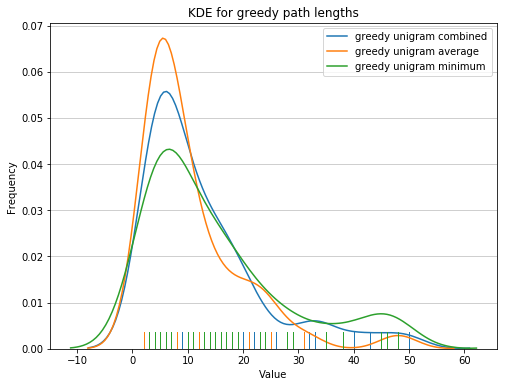

In [80]:
plot_results([results_greedy_w_c, results_greedy_w_a, results_greedy_w_m],
                              ['greedy unigram combined', 'greedy unigram average', 'greedy unigram minimum', 'greedy bigram combined', 'greedy bigram average', 'greedy bigram minimum'],
                              title="KDE for greedy path lengths", save_to_file='greedy_unigrams.png')

{'greedy bigram average': 55,
 'greedy bigram combined': 17,
 'greedy bigram minimum': 38}

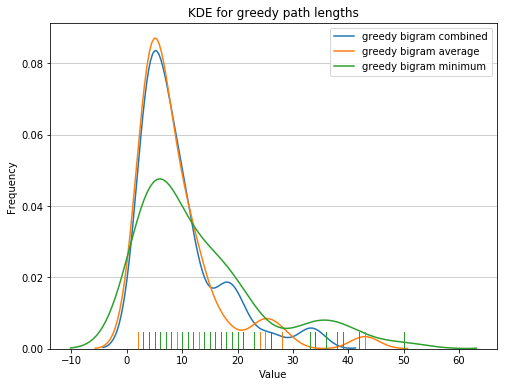

In [81]:
plot_results([results_greedy_p_c, results_greedy_p_a, results_greedy_p_m],
             ['greedy bigram combined', 'greedy bigram average', 'greedy bigram minimum'],
                              title="KDE for greedy path lengths", save_to_file='greedy_bigrams.png')

In [94]:
results_a_star = {k: v[0] for k, v in results_new_astar_exclusions.items()}

{'a star bigrams': 11, 'greedy bigram combined': 17}

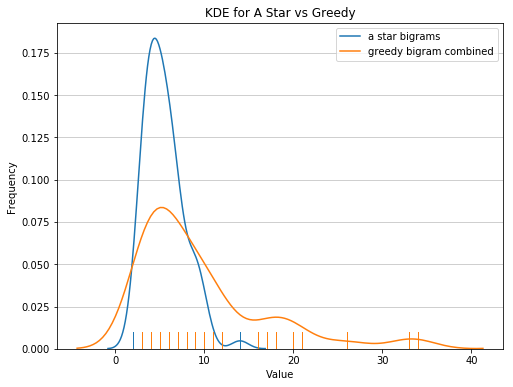

In [95]:
plot_results([results_a_star, results_greedy_p_c, results_greedy_w_m],
                              ['a star bigrams', 'greedy bigram combined'],
                              title="KDE for A Star vs Greedy", save_to_file='a_star_greedy.png')

In [177]:
failures
failures['a star bigrams'] = 11
import pandas as pd
df = pd.DataFrame.from_dict(list(failures.items()))
df.columns = ['algorithm','num_failed']
df

,algorithm,num_failed
0,greedy unigram combined,25
1,greedy unigram average,59
2,greedy unigram minimum,53
3,greedy bigram combined,17
4,greedy bigram average,55
5,greedy bigram minimum,38
6,a star bigrams,11


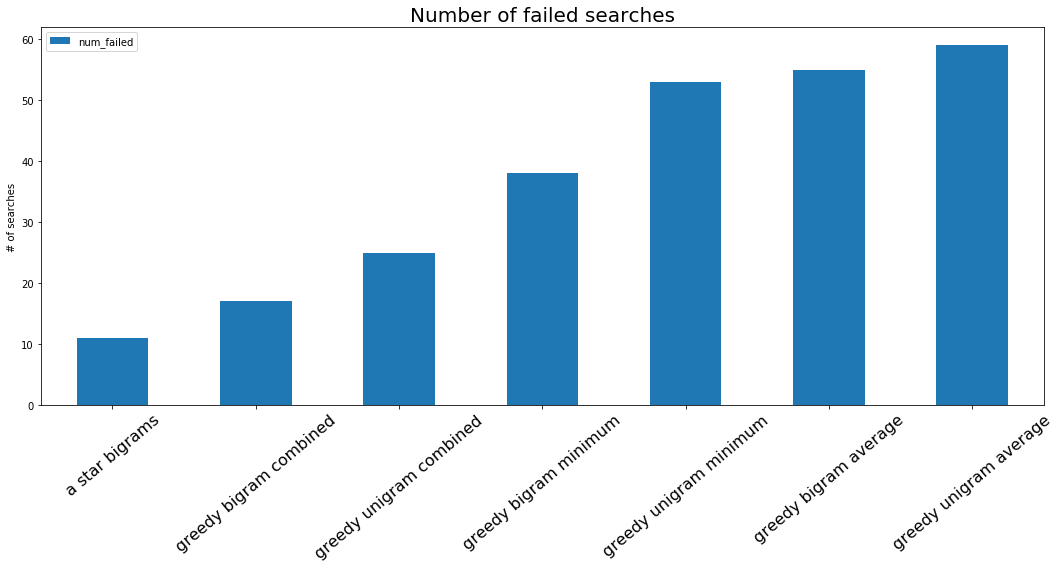

In [98]:
df = df.sort_values(by='num_failed', ascending=True)
df.plot.bar(stacked=False, figsize=(15,8))
plt.xticks(rotation=40, fontsize=16)
plt.title("Number of failed searches", fontsize=20)
plt.ylabel('# of searches')
plt.xticks(np.arange(len(df)), df['algorithm'])
plt.tight_layout()
plt.savefig("failed_searches.png")
plt.show()

### Estimate branching factor

In [122]:
links = []

for w in examples:
    p = pywikibot.Page(site, w[0])
    links.append([i.title() for i in p.linkedPages()])

In [138]:
results = np.concatenate(links)
good_results = [l for l in results if valid_page(l)]

In [141]:
len(good_results) / len(examples)

685.16

### Combining BFS and DFS

In [150]:
# pickle.dump(results_dfs, open('results/bidirectional_dfs.pkl', 'wb'))
# pickle.dump(results_bfs, open('results/bidirectional_bfs.pkl', 'wb'))

In [151]:
results_dfs = pickle.load(open('results/bidirectional_dfs.pkl', 'rb'))
results_bfs = pickle.load(open('results/bidirectional_bfs.pkl', 'rb'))

In [164]:
# for k, v in results_dfs.items():
#     print(k, v)
#     print(len(v[0]))
# #     print(k, len(v[0]))

In [165]:
# results_dfs_pathlengths = {k: len(v[0]) for k, v in results_dfs.items()}

In [184]:
trouble = ('Statistics', 'angelina jolie')

In [186]:
results_bfs[trouble]

(False, 601)

In [192]:
failures_dfs = 0
for k, v in results_dfs.items():
    if v[0] == False:
        failures_dfs += 1
failures_dfs

2

In [ ]:
for k, v in results_dfs:

In [193]:
failures
failures['a star bigrams'] = 11
failures['bidirectional dfs'] = 2
failures['bidirectional bfs'] = 2
import pandas as pd
df = pd.DataFrame.from_dict(list(failures.items()))
df.columns = ['algorithm','num_failed']
df

,algorithm,num_failed
0,greedy unigram combined,25
1,greedy unigram average,59
2,greedy unigram minimum,53
3,greedy bigram combined,17
4,greedy bigram average,55
5,greedy bigram minimum,38
6,a star bigrams,11
7,bidirectional dfs,2
8,bidirectional bfs,2


### Calculate average path lengths

In [209]:
# For simple paths
def calc_avg_paths(results):
    path_lengths = []
    for k, v in results.items():
        if len(v) > 0:
            path_lengths.append(len(v))
    return np.mean(path_lengths)

In [216]:
# For dictionaries with paths and nodes expanded
def calc_avg_paths_2(results):
    path_lengths = []
    for k, v in results.items():
        if v[0]:
            path_lengths.append(len(v[0]))
    return np.mean(path_lengths)

In [239]:
all_path_lengths = list(map(calc_avg_paths,
                            (results_greedy_w_c, results_greedy_w_a, results_greedy_w_m, 
                             results_greedy_p_c, results_greedy_p_a, results_greedy_p_m, 
                             results_a_star))) + list(map(calc_avg_paths_2, (results_dfs, results_bfs)))

In [256]:
df['avg_path'] = all_path_lengths
df['nodes_expanded'] = all_path_lengths

In [257]:
results_a_star_nodecounts = {k: v[1] for k, v in results_new_astar_exclusions.items()}

In [260]:
df.loc[6, 'nodes_expanded']

5.47191011235955

In [275]:
df.loc[6, 'nodes_expanded'] = np.mean([v for k, v in results_a_star_nodecounts.items()])
df.loc[7, 'nodes_expanded'] = np.mean([v[1] for k, v in results_dfs.items()])
df.loc[8, 'nodes_expanded'] = np.mean([v[1] for k, v in results_bfs.items()])

In [276]:
df

,algorithm,num_failed,avg_path,nodes_expanded
0,greedy unigram combined,25,12.760000,12.760000
1,greedy unigram average,59,10.585366,10.585366
2,greedy unigram minimum,53,14.957447,14.957447
3,greedy bigram combined,17,9.481928,9.481928
4,greedy bigram average,55,9.022222,9.022222
5,greedy bigram minimum,38,13.193548,13.193548
6,a star bigrams,11,5.471910,13.780000
7,bidirectional dfs,2,10.357143,15.950000
8,bidirectional bfs,2,3.928571,36.890000
